# Fundamentals of Machine Learning - Exercise 5
* We will learn how to use another clustering algorithm - **Hierarchical (or Agglomerative) clustering**.
* The base principles and important hyper-parameters will be explained.

![meme04](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_05_meme_04.jpg?raw=true)

<!-- ![meme03](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_05_meme_03.png?raw=true) -->

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, io

# Downlaod the data and unzip it

In [2]:
zip_file_url = r'https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/raw/master/datasets/data_clustering.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# 💡 Lets take a look at our data files first

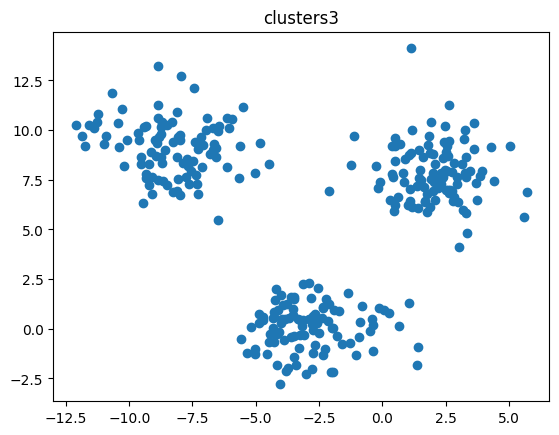

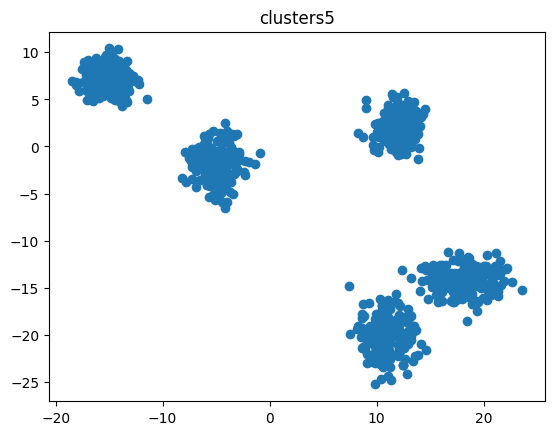

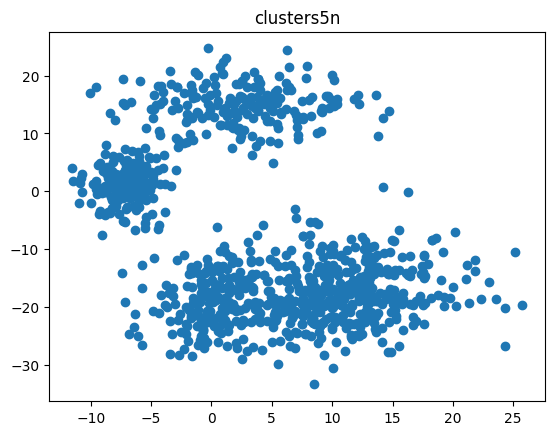

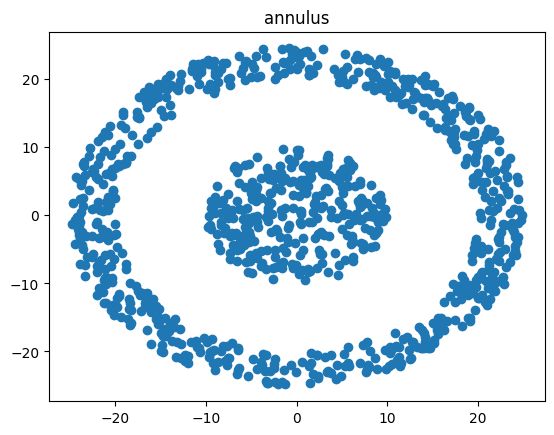

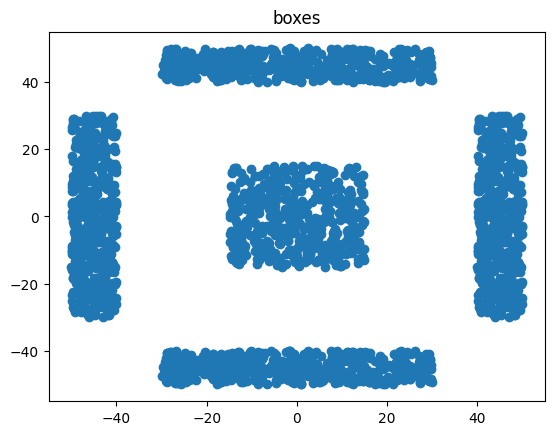

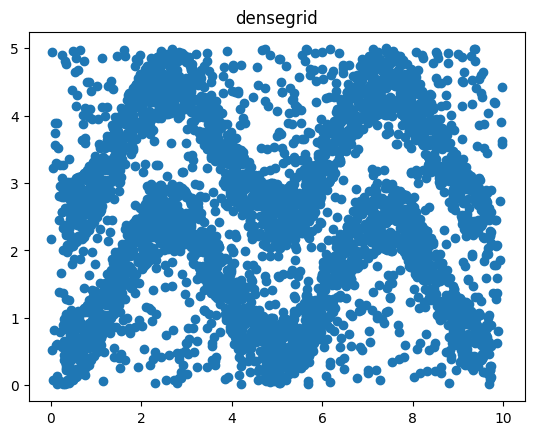

In [35]:
datasets = dict()
for data_file in ['clusters3', 'clusters5', 'clusters5n', 'annulus', 'boxes', 'densegrid']:
    data = np.loadtxt(f'{data_file}.csv', delimiter=';')
    datasets[data_file] = data
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1])
    plt.title(data_file)

# 🔎 Why do we have multiple clustering methods?
* 🔎 Why isn't k-means enough?

![meme01](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_05_meme_01.png?raw=true)

# 📊 Agglomerative clustering
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
- Take a look at https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering

* 💡 Agglomerative clustering is a **bottom-up approach** to clustering.
    * We first divide **each instance into its own cluster** and **merge them into couples** based on a similarity metric.
    * Subsequently we compute the **similarity** again and **merge the couples into bigger groups** (clusters).
    * These groups are then merged into the bigger ones **till there is only a one big group containing all the instances present at the top**.

### 🚀 **We don't have to know the number of clusters beforehand.**  
* 💡 We can perform the whole clustering process and **select the appropriate number of clusters afterward** based on the obtained results.
* We usually use the **dendrogram** for the distance threshold estimation.

## 🔎 You may ask how is the similarity among groups computed.
* 💡 **Similarity is pretty hard to define.**
* There are various ways how we can compute the value called **Linkage**.

![meme02](https://github.com/rasvob/VSB-FEI-Fundamentals-of-Machine-Learning-Exercises/blob/master/images/fml_05_meme_02.jpg?raw=true)

## 💡 Linkage variants
- **Maximum or Complete linkage**:
    - The distance between two clusters is defined as the maximum value of all pairwise distances between the elements in cluster 1 and the elements in cluster 2.
    - It tends to produce more compact clusters.
    - It is less prone to outliers than Single linkage.
    - Complete linkage methods tend to break large clusters.


- **Minimum or Single linkage**:
    - The distance between two clusters is defined as the minimum value of all pairwise distances between the elements in cluster 1 and the elements in cluster 2.
    - It tends to produce long, “loose” clusters.
    - Single linkage method is prone to "chain" and form clusters of irregular, often thread-like curved shapes.
        - The reason for that is obvious. With this method, at any step, **two clusters are merged if their closest edges are close enough**.
        - No proximity between other parts of the two clusters is taken into consideration.


- **Mean or Average linkage**:
    - The distance between two clusters is defined as the average distance between the elements in cluster 1 and the elements in cluster 2.

## We are going to take a look at dendrogram, but we will be using only smaller portion of data *clusters3* for now
* Use `np.random.choice` for choosing only 30 samples
* Check the shape of the data

In [36]:
data = datasets['clusters3']
data_subset = data[np.random.choice(data.shape[0], 30, replace=False)]
data_subset.shape

(30, 2)

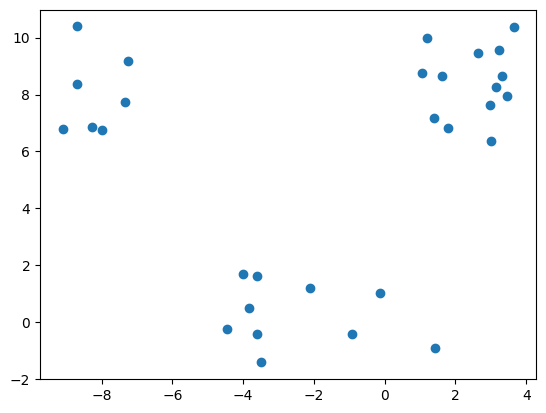

In [38]:
plt.scatter(data_subset[:, 0], data_subset[:, 1])

In [39]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Credit to https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(linkage_matrix, **kwargs)
    plt.ylabel('distance')

# 🎯 Complete linkage

## We need to calculate whole hiearchical clustering tree before dendrogram calculation

- 💡 We can achieve this by setting distance_threshold=0, n_clusters=None in sklearn.cluster.AgglomerativeClustering

- Notice the height of the vertcal lines in the denrogram - the higher the line (called fusion), the lower is the similarity between the clusters.
- This similarity is called cophenetic distance.

* In scikit.learn we have the `AgglomerativeClustering` class
    * Important parameters are *linkage, distance_threshold* and *n_clusters*
    * And also there is the *fit()* method as usual

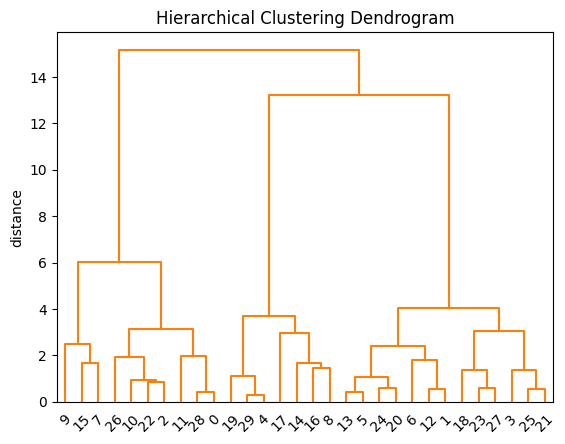

In [40]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(data_subset)

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)

## 🔎 What can be an ideal level for splitting our data to clusters?

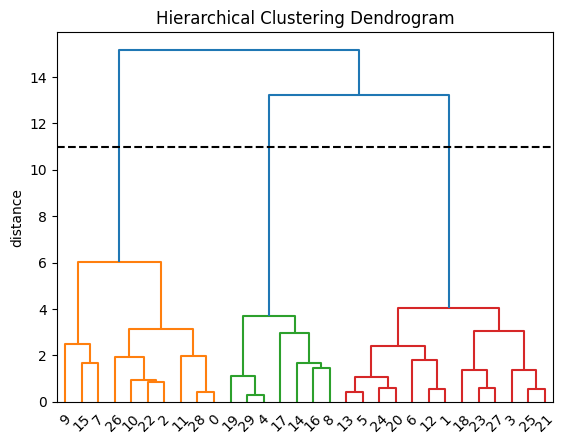

In [41]:
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=11)
plt.axhline(y=11, color='black', linestyle='--')

## 🚀 Create dendrogram for the full dataset

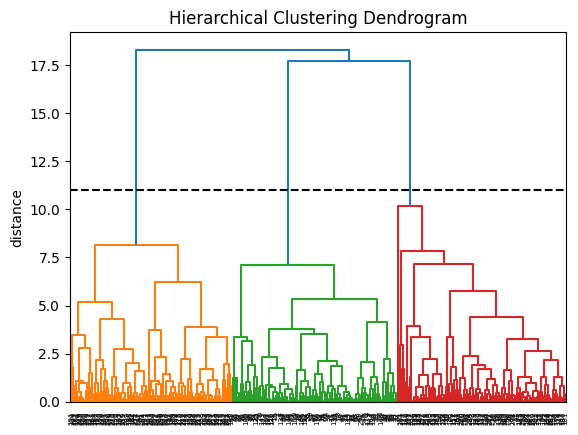

In [42]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(data)

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=11)
plt.axhline(y=11, color='black', linestyle='--')

# Let's generate clustering results and use sccater plot for visualizion for our 2D toy datasets

* We can use **one of following parameters** to obtain our clusters from AgglomerativeClustering:
    - **distance_thrashold** - this is effectively the split line above
        - i.e. if the distance between two clusters is higher than the *distance_thrashold*, then these clusters won't be merged
    - **n_clusters** - similar to the k-means *k* parameter

## 💡 We can start with `distance_threshold` and set it to `11`

In [43]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=11, n_clusters=None)
clustering = clustering.fit(data)
pd.Series(clustering.labels_).value_counts()

,count
0,102
2,100
1,98


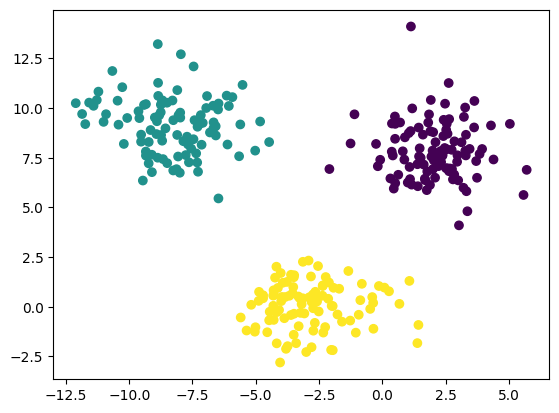

In [44]:
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

## 💡  We can also specify number of clusters directly
* Set `n_clusters` to `3`

In [45]:
n_clusters = 3
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=None, n_clusters=n_clusters)
clustering = clustering.fit(data)
pd.Series(clustering.labels_).value_counts()

,count
0,102
2,100
1,98


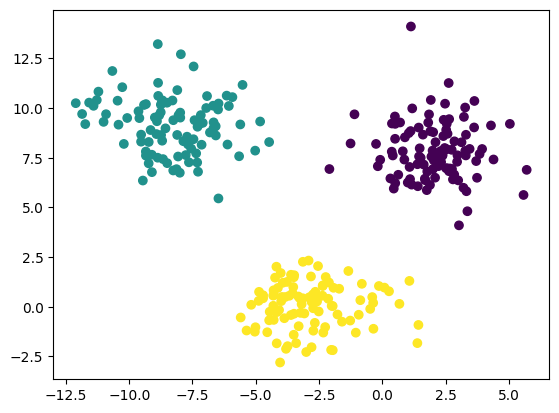

In [46]:
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

# 🎯 Single linkage

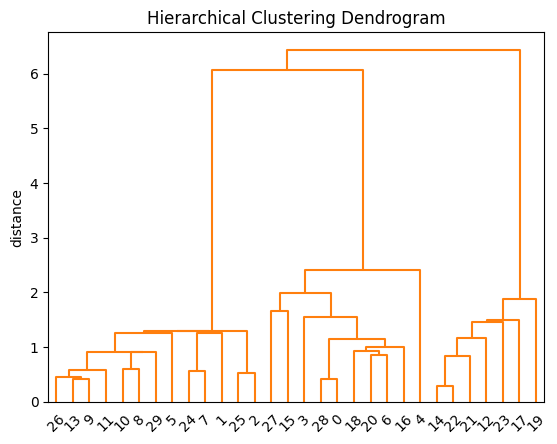

In [60]:
clustering = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(data_subset)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)

## 🔎 What is the appropriate number of clusters?
* Use `distance_threshold` to set it and take a look at how big are the clusters

In [61]:
clustering = AgglomerativeClustering(linkage='single', distance_threshold=3, n_clusters=None)
clustering = clustering.fit(data_subset)
pd.Series(clustering.labels_).value_counts()

,count
2,13
0,10
1,7


# 🔎 What is the difference between this and complete linkage?

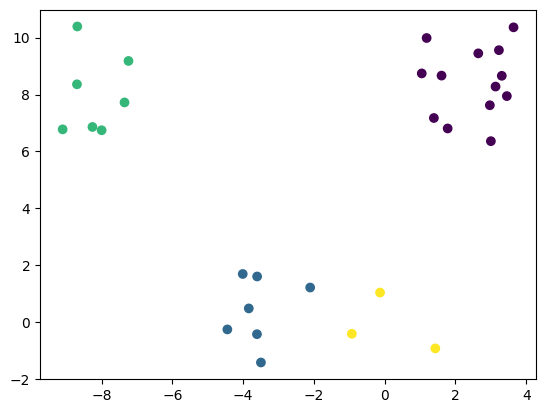

In [65]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=5, n_clusters=None)
clustering = clustering.fit(data_subset)
plt.scatter(data_subset[:,0], data_subset[:,1], c=clustering.labels_)

# We can use Agglomerative clustering for the annulus dataset as well

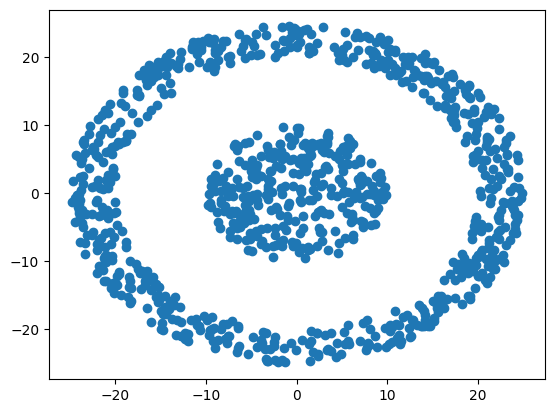

In [63]:
data = datasets['annulus']
plt.scatter(data[:,0], data[:,1])

# 🎯 Complete linkage

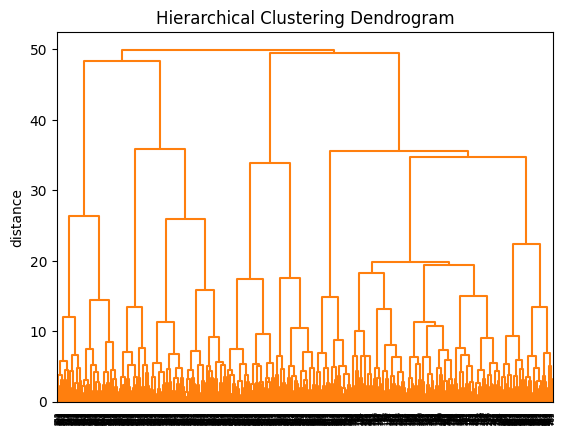

In [66]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(data)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)

## Four clusters seems OK, so let's try it ✊

In [68]:
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=None, n_clusters=4)
clustering = clustering.fit(data)
pd.Series(clustering.labels_).value_counts()

,count
1,477
0,219
2,179
3,125


## Does it seem OK now?

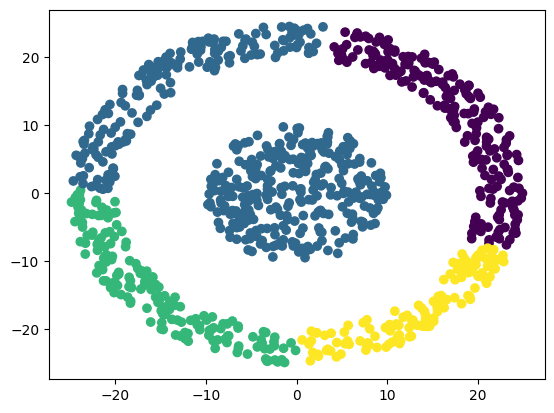

In [69]:
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

# 🎯 Single linkage

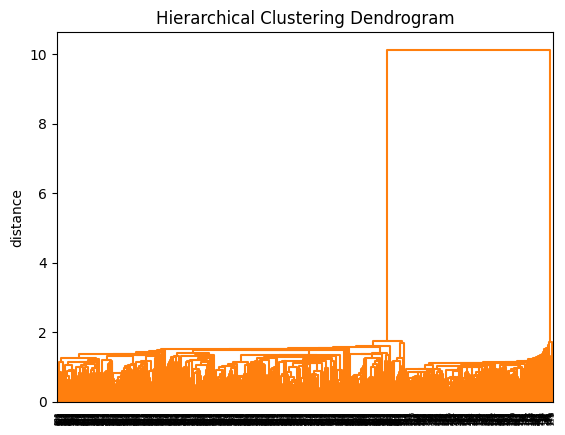

In [70]:
clustering = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(data)

plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)
plt.show()

## Let's try with two clusters now

In [22]:
clustering = AgglomerativeClustering(linkage='single', distance_threshold=None, n_clusters=2)
clustering = clustering.fit(data)
pd.Series(clustering.labels_).value_counts()

,count
0,700
1,300


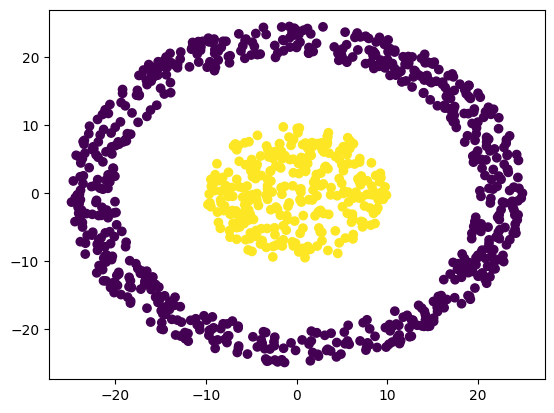

In [23]:
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

# 🚀 We have seen, that there is no clear winner among linkage parameters
- It depends solely on the dataset
- **No Free Lunch Theorem** - see https://machinelearningmastery.com/no-free-lunch-theorem-for-machine-learning/

## For more clustering information you can take a look at [documentation](https://scikit-learn.org/stable/modules/clustering.html#clustering)

# ✅ Task (2p)
- Use **Agglomerative Clustering** on **clusters5** and **densegrid** datasets
- Detect "ideal" number of clusters using the dendrogram
- **Use both, the single and complete linkage and compare the results of the clustering methods**
    - How are the selected clusters aligned with the raw data (use scatter plots)?
    - i.e. You can guess the right number of clusters by taking a look at the data, but is the result of the algorithm right from your point of view?

* **Describe the insight you got from the plots with a few sentences in a Markdown cell below the plot**
  * ❌ Plot interpretation figured in real-time during task check is not allowed! ❌

,count
0,199
1,100
2,1


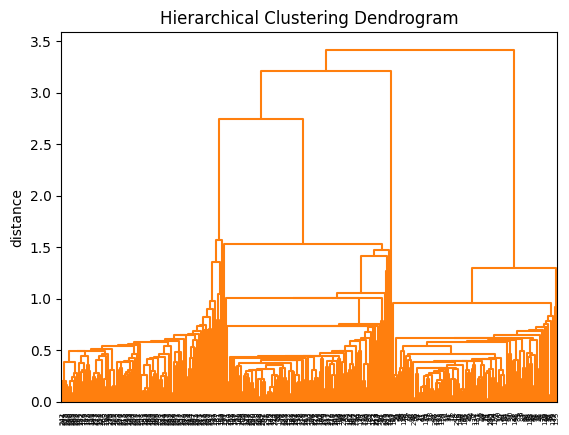

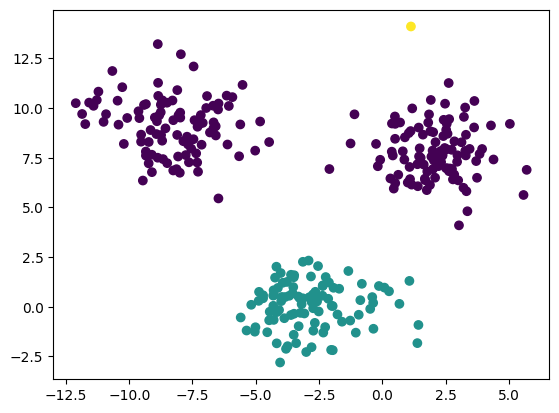

In [75]:
ds_c3 = datasets['clusters3']
clustering = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(ds_c3)

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)
plt.figure()
clustering = AgglomerativeClustering(linkage='single', distance_threshold=3, n_clusters=None)
clustering = clustering.fit(ds_c3)

plt.scatter(ds_c3[:,0], ds_c3[:,1], c=clustering.labels_)
pd.Series(clustering.labels_).value_counts()

,count
0,102
2,100
1,98


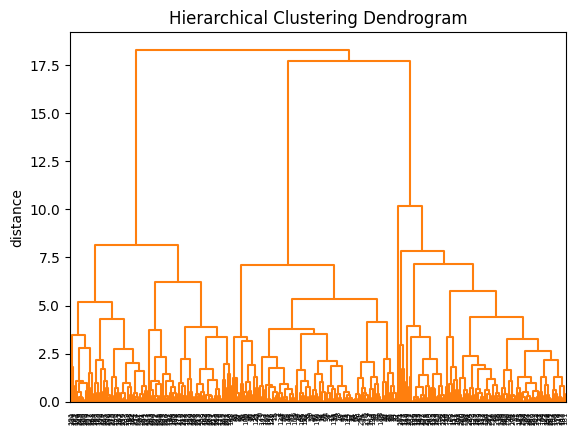

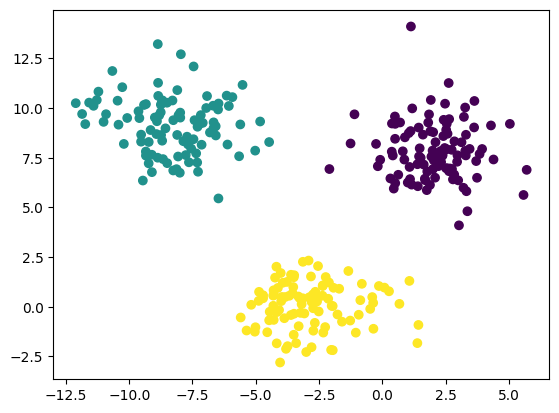

In [77]:

ds_c3 = datasets['clusters3']
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(ds_c3)

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)
plt.figure()
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=12.5, n_clusters=None)
clustering = clustering.fit(ds_c3)

plt.scatter(ds_c3[:,0], ds_c3[:,1], c=clustering.labels_)
pd.Series(clustering.labels_).value_counts()

,count
0,3999
1,1


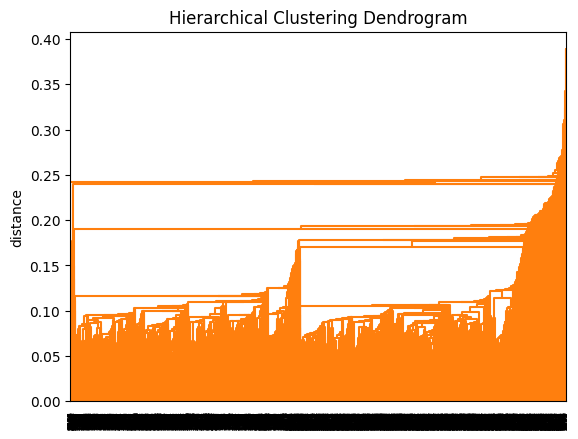

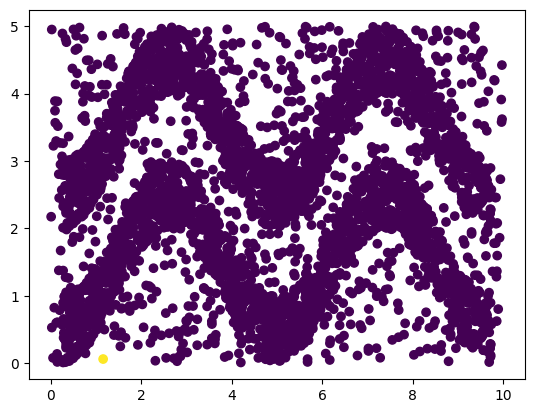

In [83]:
ds_dense = datasets['densegrid']
clustering = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(ds_dense)

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)
plt.figure()
clustering = AgglomerativeClustering(linkage='single', distance_threshold=0.35, n_clusters=None)
clustering = clustering.fit(ds_dense)

plt.scatter(ds_dense[:,0], ds_dense[:,1], c=clustering.labels_)
pd.Series(clustering.labels_).value_counts()

,count
0,1766
2,1161
1,1073


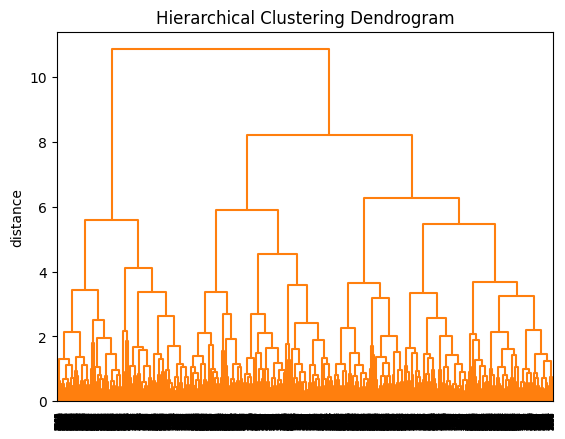

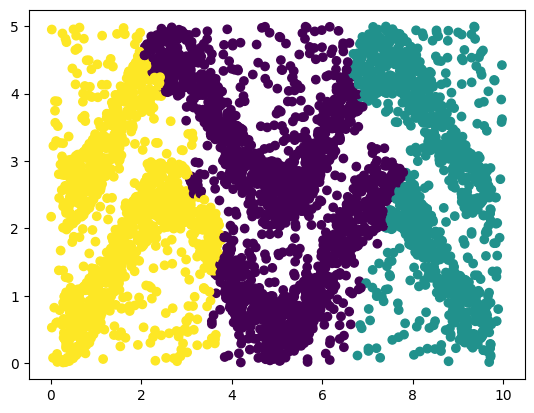

In [82]:
ds_dense = datasets['densegrid']
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=0, n_clusters=None)
clustering = clustering.fit(ds_dense)

plot_dendrogram(clustering, labels=clustering.labels_, color_threshold=999)
plt.figure()
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=7, n_clusters=None)
clustering = clustering.fit(ds_dense)

plt.scatter(ds_dense[:,0], ds_dense[:,1], c=clustering.labels_)
pd.Series(clustering.labels_).value_counts()

#Single linkage

„Vzdálenost dvou shluků = vzdálenost mezi jejich nejbližšími body.“

#Complete linkage
„Vzdálenost dvou shluků = vzdálenost mezi jejich nejvzdálenějšími body.“